
[![Udacity - Self-Driving Car NanoDegree](https://s3.amazonaws.com/udacity-sdc/github/shield-carnd.svg)](http://www.udacity.com/drive)
## Dean Webb - Advanced Lane Line Tracking Pipeline

In this project, our goal is to write a software pipeline to identify the lane boundaries in a video, but the main output or product we want you to create is a detailed writeup of the project.  Check out the [writeup template](https://github.com/udacity/CarND-Advanced-Lane-Lines/blob/master/writeup_template.md) for this project and use it as a starting point for creating your own writeup.    

Project Goals:
---

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

The images for camera calibration are stored in the folder called `camera_cal`.  The images in `test_images` are for testing your pipeline on single frames.  If you want to extract more test images from the videos, you can simply use an image writing method like `cv2.imwrite()`, i.e., you can read the video in frame by frame as usual, and for frames you want to save for later you can write to an image file.  

To help the reviewer examine your work, please save examples of the output from each stage of your pipeline in the folder called `ouput_images`, and include a description in your writeup for the project of what each image shows.    The video called `project_video.mp4` is the video your pipeline should work well on.  

The `challenge_video.mp4` video is an extra (and optional) challenge for you if you want to test your pipeline under somewhat trickier conditions.  The `harder_challenge.mp4` video is another optional challenge and is brutal!

### Import Dependencies

In [1]:
# Camera Calibration
import numpy as np
import cv2
import glob
import pickle
import os

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

### Constants

In [2]:
WORKING_DIRECTORY = 'data/'
IMAGE_EXTENSION = '.jpg'
OUTPUT_DIRECTORY = 'output_images/'
DATACACHE_DIRECTORY = "datacache/"

# Calibration Constants #
CALIBRATION_DIRECTORY = 'camera_cal/'
CALIBRATION_PREFIX = 'corners_found'
calibration_path = "{}{}{}".format(WORKING_DIRECTORY, CALIBRATION_DIRECTORY, '*'+IMAGE_EXTENSION)
CHESSBOARD_SIZE = (9,6)

# Threshold Constants #
TEST_IMAGE_DIRECTORY = "test_images/"
THRESHOLDING_PREFIX = "thresholded"
COLOR_STACKED_PREFIX = "color_stacked"
UNDISTORTED_PREFIX = "undistorted"
test_images_path = "{}{}{}".format(WORKING_DIRECTORY, TEST_IMAGE_DIRECTORY, 'test*'+IMAGE_EXTENSION)


### Camera Calibration

In [3]:
# Calibrate the camera using a 9x6 checkerboard
objp = np.zeros((CHESSBOARD_SIZE[1]*CHESSBOARD_SIZE[0], 3), np.float32)
objp[:,:2] = np.mgrid[0:CHESSBOARD_SIZE[0], 0:CHESSBOARD_SIZE[1]].T.reshape(-1, 2)

# Arrays to store object points and image points from all the images
objpoints = [] # 3-Dim points in real-world space
imgpoints = [] # 2-Dim points in virtual image plane

# Load Calibration Images 
calibration_images = glob.glob(calibration_path, recursive=True)

# Walk through images and search for checkerboard corners
for idx, fname in enumerate(calibration_images):
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Find the checkerboard corners
    ret, corners = cv2.findChessboardCorners(gray, CHESSBOARD_SIZE, None)
    
    # If found, add object points, image points
    if ret == True:
        print('Calibrating image:', fname)
        imgpoints.append(corners)
        objpoints.append(objp)
        
        # Draw and display found corners
        cv2.drawChessboardCorners(img, CHESSBOARD_SIZE, corners, ret)
        output_img_path = "{}{}{}{}{}".format(WORKING_DIRECTORY, OUTPUT_DIRECTORY, CALIBRATION_PREFIX
                                              ,str(idx), IMAGE_EXTENSION)
        print('Saving Calibrated image:', output_img_path)
        if not os.path.exists(WORKING_DIRECTORY):
            os.mkdir(WORKING_DIRECTORY)
        elif not os.path.exists(os.path.join(WORKING_DIRECTORY, OUTPUT_DIRECTORY)):
            os.mkdir(os.path.join(WORKING_DIRECTORY, OUTPUT_DIRECTORY))    
        cv2.imwrite(output_img_path, img)

Calibrating image: data/camera_cal/calibration10.jpg
Saving Calibrated image: data/output_images/corners_found1.jpg
Calibrating image: data/camera_cal/calibration11.jpg
Saving Calibrated image: data/output_images/corners_found2.jpg
Calibrating image: data/camera_cal/calibration12.jpg
Saving Calibrated image: data/output_images/corners_found3.jpg
Calibrating image: data/camera_cal/calibration13.jpg
Saving Calibrated image: data/output_images/corners_found4.jpg
Calibrating image: data/camera_cal/calibration14.jpg
Saving Calibrated image: data/output_images/corners_found5.jpg
Calibrating image: data/camera_cal/calibration15.jpg
Saving Calibrated image: data/output_images/corners_found6.jpg
Calibrating image: data/camera_cal/calibration16.jpg
Saving Calibrated image: data/output_images/corners_found7.jpg
Calibrating image: data/camera_cal/calibration17.jpg
Saving Calibrated image: data/output_images/corners_found8.jpg
Calibrating image: data/camera_cal/calibration18.jpg
Saving Calibrated i

### Save Calibration Variables to Pickle File

In [4]:
# Load image for reference
img = cv2.imread(calibration_images[0])
img_size = (img.shape[1], img.shape[0])

# Perform calibration given object points and image points
ret, mtx, dist, _, _ = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

# Save camera calibration result data
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist

if not os.path.exists(WORKING_DIRECTORY):
    os.mkdir(WORKING_DIRECTORY)
elif not os.path.exists(os.path.join(WORKING_DIRECTORY, DATACACHE_DIRECTORY)):
    os.mkdir(os.path.join(WORKING_DIRECTORY, DATACACHE_DIRECTORY))
    
pickle_file = os.path.join(WORKING_DIRECTORY, DATACACHE_DIRECTORY, "calibration_pickle.p")

pickle.dump(dist_pickle, open(pickle_file, "wb"))

### Undistort Test Images

In [5]:
import pickle
#from tracker import tracker

# Read in the saved objpoints and imgpoints
dist_pickle = pickle.load( open(pickle_file, "rb"))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

### Sobel and Gradient Thresholding

In [6]:
def abs_sobel_thresh(sobel_img, sobel_kernel=9, thresh=(20, 100)):
    # Take the absolute value on Sobel function
    abs_sobel = np.absolute(sobel_img)
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

In [7]:
def mag_threshold(sobelx, sobely, sobel_kernel=9, mag_thresh=(0, 255)):
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return mag_binary

In [8]:
def dir_threshold(sobelx, sobely, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return dir_binary

In [9]:
def window_mask(width, height, img_ref, center, level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),
          max(0, int(center-width))]

In [10]:
def apply_thresholds(img, kernel_size=9, l_thresh=(115, 130), v_thresh=(190, 255), s_thresh=(150, 255), sx_thresh=(19, 100), sy_thresh=(25, 40)):   
    img = np.copy(img)

    # Convert to HLS color space and separate the S and L channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float)
    v_channel = hsv[:,:,2]

    # Threshold l-channel
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    # Threshold s-channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Threshold v-channel
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel >= v_thresh[0]) & (v_channel <= v_thresh[1])] = 1
    
    # Sobel Operator
    sobelx = cv2.Sobel(v_channel, cv2.CV_64F, 1, 0, ksize=kernel_size)
    sobely = cv2.Sobel(v_channel, cv2.CV_64F, 0, 1, ksize=kernel_size)

    # Calculate Abs value and Threshold pixels after Sobel Operator
    gradx_binary = abs_sobel_thresh(sobelx, sobel_kernel=15, thresh=sx_thresh)
    grady_binary = abs_sobel_thresh(sobely, sobel_kernel=15, thresh=sy_thresh)
    
    # Threshold magnitude and direction gradients
    mag_binary = mag_threshold(sobelx, sobely, sobel_kernel=kernel_size, mag_thresh=(30, 100))
    dir_binary = dir_threshold(sobelx, sobely, sobel_kernel=15, thresh=(0.7, 1.3))

    # Stack 2 channels for color_binary
    color_binary = np.dstack(( l_binary, s_binary, v_binary))

    combined = np.zeros_like(s_channel)
    
    combined[((v_binary == 1) & (s_binary == 1)) |
            ((gradx_binary == 1) & (v_binary == 1)) |
            ((mag_binary == 1) & (dir_binary == 1)) |
            ((l_binary == 1) & (mag_binary == 1) & (dir_binary == 1)) |
            ((mag_binary == 1) & (v_binary == 1)) ] = 1
        
    return color_binary, combined

# Load Test Images
test_images = glob.glob(test_images_path, recursive=True)

# Walk through test images
for idx, fname in enumerate(test_images):
    img = mpimg.imread(fname)
    
    # Undistort the image
    img = cv2.undistort(img, mtx, dist, None, mtx)

    color_binary, combined_binary = apply_thresholds(img)
    
    undistorted_img_path = "{}{}{}{}{}".format(WORKING_DIRECTORY, OUTPUT_DIRECTORY, UNDISTORTED_PREFIX
                                              ,str(idx), IMAGE_EXTENSION)
    
    color_stacked_img_path = "{}{}{}{}{}".format(WORKING_DIRECTORY, OUTPUT_DIRECTORY, COLOR_STACKED_PREFIX
                                              ,str(idx), IMAGE_EXTENSION)
    
    thresholded_img_path = "{}{}{}{}{}".format(WORKING_DIRECTORY, OUTPUT_DIRECTORY, THRESHOLDING_PREFIX
                                              ,str(idx), IMAGE_EXTENSION)
    if not os.path.exists(WORKING_DIRECTORY):
        os.mkdir(WORKING_DIRECTORY)
    elif not os.path.exists(os.path.join(WORKING_DIRECTORY, OUTPUT_DIRECTORY)):
        os.mkdir(os.path.join(WORKING_DIRECTORY, OUTPUT_DIRECTORY))
    
    print('Saving Undistorted Result image:', undistorted_img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.imwrite(undistorted_img_path, img)
    
    print('Saving Color Stacked image:', color_stacked_img_path)
    mpimg.imsave(color_stacked_img_path, color_binary)
    
    print('Saving Thresholded image:', thresholded_img_path)
    mpimg.imsave(thresholded_img_path, combined_binary, cmap='gray')


Saving Undistorted Result image: data/output_images/undistorted0.jpg
Saving Color Stacked image: data/output_images/color_stacked0.jpg
Saving Thresholded image: data/output_images/thresholded0.jpg
Saving Undistorted Result image: data/output_images/undistorted1.jpg
Saving Color Stacked image: data/output_images/color_stacked1.jpg
Saving Thresholded image: data/output_images/thresholded1.jpg
Saving Undistorted Result image: data/output_images/undistorted2.jpg
Saving Color Stacked image: data/output_images/color_stacked2.jpg
Saving Thresholded image: data/output_images/thresholded2.jpg
Saving Undistorted Result image: data/output_images/undistorted3.jpg
Saving Color Stacked image: data/output_images/color_stacked3.jpg
Saving Thresholded image: data/output_images/thresholded3.jpg
Saving Undistorted Result image: data/output_images/undistorted4.jpg
Saving Color Stacked image: data/output_images/color_stacked4.jpg
Saving Thresholded image: data/output_images/thresholded4.jpg
Saving Undistor

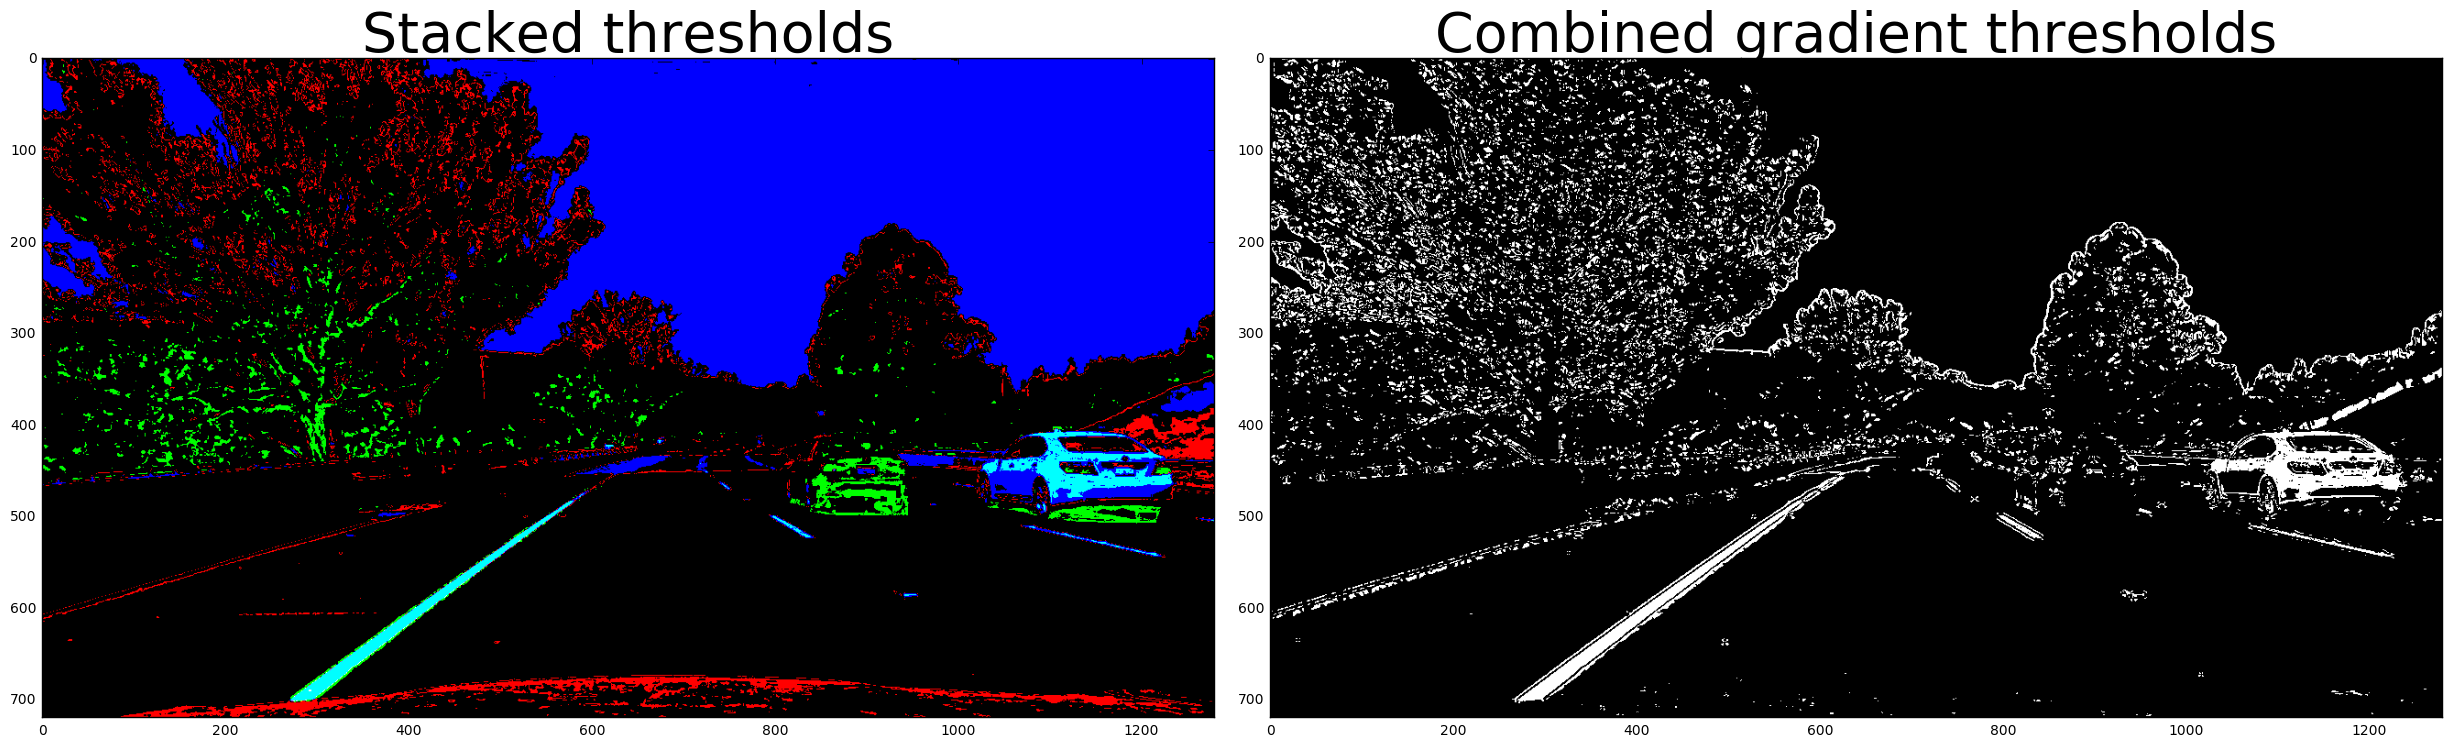

In [11]:
# Plot the last test image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(color_binary)
ax1.set_title('Stacked thresholds', fontsize=40)

ax2.imshow(combined_binary, cmap='gray')
ax2.set_title('Combined gradient thresholds', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)